# Problem Statement

The objective of this study is to classify mood of the person from facial expressions Images are categorized in three classes namely sadness, fear and happiness based on the emotion shown in the facial expressions

### Import Libraries

In [1]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Read the csv file and basic data exploration

In [2]:
df = pd.read_csv('./data/aithon2020_level2_traning.csv')

In [3]:
df.shape

(10817, 2305)

In [4]:
#Number of moods in dataset
df.emotion.unique() 

array(['Fear', 'Sad', 'Happy'], dtype=object)

In [5]:
df.head()

,emotion,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_2294,pixel_2295,pixel_2296,pixel_2297,pixel_2298,pixel_2299,pixel_2300,pixel_2301,pixel_2302,pixel_2303
0,Fear,231,212,156,164,174,138,161,173,182,...,104,138,152,122,114,101,97,88,110,152
1,Fear,55,55,55,55,55,54,60,68,54,...,90,83,77,53,37,34,30,34,30,57
2,Sad,20,17,19,21,25,38,42,42,46,...,29,36,68,91,85,93,97,99,107,118
3,Happy,4,2,13,41,56,62,67,87,95,...,59,66,80,74,69,99,28,3,7,12
4,Fear,255,255,255,255,255,255,255,255,255,...,94,21,22,51,71,80,82,79,79,83


In [6]:
missing_val_count_by_column = (df.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Series([], dtype: int64)


### Split the data into train, validation and test at ratio 80:10:10

In [7]:
traincsv, testcsv = train_test_split(df, test_size=0.1)
testcsv.shape

(1082, 2305)

### Traing the data the data

In [8]:
train, validation = train_test_split(traincsv, test_size=0.1111)
print(train.shape)
print(validation.shape)

(8653, 2305)
(1082, 2305)


In [9]:
def getImageinDirectory(train):
    fear = 0
    happy = 0
    sad = 0
    mat = np.zeros((48,48),dtype=np.uint8)
    for i in range(len(train)):
        words=train.iloc[i,1:].values
        # the image size is 48x48
        for j in range(2304):
            xind = j // 48
            yind = j % 48
            mat[xind][yind] = words[j]

        img = Image.fromarray(mat)
        if train.iloc[i,0] == 'Fear':
            img.save('./source/'+train.name+'/fear/fear'+str(fear)+'.png')
            fear += 1
        elif train.iloc[i,0] == 'Happy':
            img.save('./source/'+train.name+'/happy/happy'+str(happy)+'.png')
            happy += 1
        elif train.iloc[i,0] == 'Sad': 
            img.save('./source/'+train.name+'/sad/sad'+str(sad)+'.png')
            sad += 1

In [10]:
train.name='train'
validation.name='validation'
getImageinDirectory(validation);
getImageinDirectory(train);

In [11]:
train_dir = './source/train'
val_dir = './source/validation'

num_train = len(train)
num_val = len(validation)
batch_size = 32
num_epoch = 50

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

Found 8653 images belonging to 3 classes.
Found 1082 images belonging to 3 classes.


#### Create a CNN model and train it

In [13]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [14]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
model_info = model.fit_generator(
            train_generator,
            steps_per_epoch=num_train // batch_size,
            epochs=num_epoch,
            validation_data=validation_generator,
            validation_steps=num_val // batch_size)
model.save_weights('./source/model.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 270 steps, validate for 33 steps
Epoch 1/50
270/270 [==============================] - 61s 225ms/step - loss: 1.0681 - accuracy: 0.4504 - val_loss: 1.0779 - val_accuracy: 0.4223
Epoch 2/50
270/270 [==============================] - 62s 230ms/step - loss: 1.0274 - accuracy: 0.4860 - val_loss: 0.9841 - val_accuracy: 0.5284
Epoch 3/50
270/270 [==============================] - 67s 249ms/step - loss: 0.9456 - accuracy: 0.5532 - val_loss: 0.9231 - val_accuracy: 0.5814
Epoch 4/50
270/270 [==============================] - 64s 238ms/step - loss: 0.8944 - accuracy: 0.5831 - val_loss: 0.8711 - val_accuracy: 0.6098
Epoch 5/50
270/270 [==============================] - 66s 244ms/step - loss: 0.8487 - accuracy: 0.6060 - val_loss: 0.8289 - val_accuracy: 0.6259
Epoch 6/50
270/270 [==============================] - 67s 249ms/step - loss: 0.8112 - accuracy: 0.6254 - v

#### Plot the graphs for accuracy and losses

C:\Users\SHIVAM\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
C:\Users\SHIVAM\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


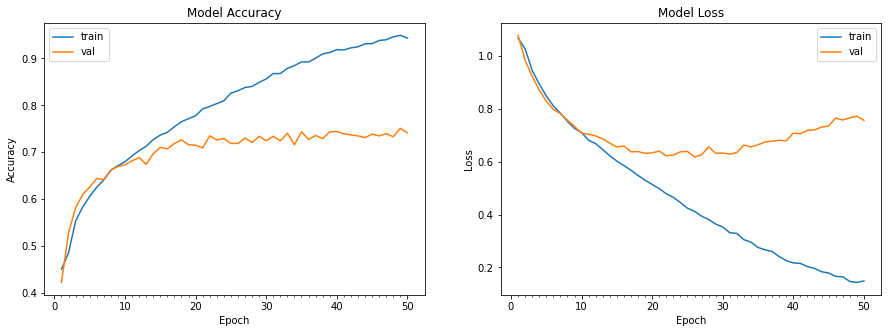

In [15]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(range(1,len(model_info.history['accuracy'])+1),model_info.history['accuracy'])
axs[0].plot(range(1,len(model_info.history['val_accuracy'])+1),model_info.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_xticks(np.arange(1,len(model_info.history['accuracy'])+1),len(model_info.history['accuracy'])/10)
axs[0].legend(['train', 'val'], loc='best')

    
axs[1].plot(range(1,len(model_info.history['loss'])+1),model_info.history['loss'])
axs[1].plot(range(1,len(model_info.history['val_loss'])+1),model_info.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_xticks(np.arange(1,len(model_info.history['loss'])+1),len(model_info.history['loss'])/10)
axs[1].legend(['train', 'val'], loc='best')
    
fig.savefig('./source/plot.png')
plt.show()

### Test the model

In [16]:
test = testcsv
test.name='test'
getImageinDirectory(test);

In [17]:
model.load_weights('./source/model.h5')

# prevents openCL usage and unnecessary logging messages
cv2.ocl.setUseOpenCL(False)

# dictionary which assigns each label an emotion (alphabetical order)

test_dir = './source/test'

test_val = len(test)
batch_size = 1

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        shuffle = False,
        class_mode='categorical')

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples)
print(predict.shape);


Found 1082 images belonging to 3 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
(1082, 3)


In [18]:
emotion_dict = {0: "Fear", 1: "Happy", 2: "Sad"}

In [19]:
prediction=[];
for i in range(len(predict)):
    prediction.append(int(np.argmax(predict[i])));    
    frame= cv2.imread('.\\source\\test\\'+filenames[i])
    facecasc = cv2.CascadeClassifier('./source/haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray,scaleFactor=1.1, minNeighbors=5)
        
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y-10), (x+w, y+h), (255, 0, 0), 2)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        maxindex = int(np.argmax(predict[i]))
        cv2.putText(frame, emotion_dict[maxindex], (x, y+w), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2, cv2.LINE_AA);
        cv2.imwrite('./source/output/'+  filenames[i] +'.png', frame)
    
cv2.waitKey(0)
cv2.destroyAllWindows();


#### Plot the confusion matrix and the accuracy

In [20]:
test_labels=test_generator.classes
cm=confusion_matrix(prediction,test_labels)
print (cm)

[[144  16  67]
 [ 29 412  42]
 [113  38 221]]


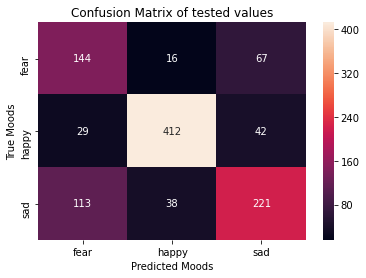

In [21]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted Moods');ax.set_ylabel('True Moods'); 
ax.set_title('Confusion Matrix of with accuracy of %s' %
                 (str(round(accuracy_score(prediction, test_labels),2))))
ax.xaxis.set_ticklabels(['fear', 'happy', 'sad']); ax.yaxis.set_ticklabels(['fear', 'happy', 'sad']);
plt.savefig('./source/confusion-matrix.png')

In [22]:
print(accuracy_score(prediction,test_labels))

0.7181146025878004


In [23]:
res = [emotion_dict[i] for i in prediction] 

In [24]:
print(res)

['Fear', 'Fear', 'Sad', 'Fear', 'Sad', 'Sad', 'Happy', 'Sad', 'Fear', 'Happy', 'Fear', 'Sad', 'Fear', 'Fear', 'Happy', 'Happy', 'Fear', 'Sad', 'Fear', 'Fear', 'Fear', 'Sad', 'Fear', 'Sad', 'Fear', 'Sad', 'Sad', 'Fear', 'Fear', 'Fear', 'Fear', 'Sad', 'Fear', 'Sad', 'Sad', 'Sad', 'Fear', 'Happy', 'Happy', 'Sad', 'Fear', 'Fear', 'Fear', 'Sad', 'Happy', 'Fear', 'Fear', 'Fear', 'Fear', 'Sad', 'Fear', 'Sad', 'Fear', 'Fear', 'Fear', 'Fear', 'Fear', 'Sad', 'Fear', 'Fear', 'Fear', 'Fear', 'Sad', 'Sad', 'Fear', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad', 'Fear', 'Fear', 'Sad', 'Fear', 'Sad', 'Fear', 'Happy', 'Fear', 'Sad', 'Sad', 'Happy', 'Fear', 'Fear', 'Sad', 'Fear', 'Fear', 'Fear', 'Fear', 'Sad', 'Fear', 'Fear', 'Happy', 'Sad', 'Fear', 'Fear', 'Sad', 'Sad', 'Sad', 'Happy', 'Fear', 'Fear', 'Sad', 'Fear', 'Fear', 'Sad', 'Fear', 'Sad', 'Sad', 'Fear', 'Fear', 'Happy', 'Fear', 'Sad', 'Fear', 'Happy', 'Fear', 'Sad', 'Happy', 'Fear', 'Fear', 'Sad', 'Fear', 'Fear', 'Fear', 'Sad', 'Sad', 'Sad', 'Sad', '

# THE END